In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

experiment_name = "M2"
__RECALLAT__ = 10

In [2]:
class Experimenter:
    def __init__(self, experiment_name):
        self._files = []
        self.experiment_name = experiment_name
    def append(self, recommender_list, forgetting_list, parameters_list):
        for r in recommender_list:
            for p in parameters_list:
                for f in forgetting_list:
                    self._files.append("{}_{}_{}_{}.dat".format(r, f, p, self.experiment_name))
    def __getitem__(self, position):
        return self._files[position]

In [3]:
experimenter = Experimenter(experiment_name)
recommender_list = ["MFRecommender"]
experimenter.append(recommender_list, ["ForgetUnpopularItems"], [1.2])
experimenter.append(recommender_list, ["NoForgetting"], [None])
experimenter.append(recommender_list, ["UserFactorFading"], [0.99])
experimenter.append(recommender_list, ["SDUserFactorFading"], [1.08])
experimenter.append(recommender_list, ["MappedUserFactorFading"], [1.1])

In [4]:
class Recall:
    def __init__(self, n):
        self.n = n
        self.hits = 0
        self.stream = 0 
    def update(self, rank):
        if rank <= self.n:
            self.hits += 1
        self.stream += 1
        return self.score()
    def score(self):
        return self.hits/self.stream
    
class Position:
    def update(self, rank):
        print(rank)
        return (1002 - rank)/1001

In [5]:
# (top-1 score, where the correct item is ranked, rec time, update time)

defined = False
recallDF = None
uptimeDF = None
rectimeDF = None
for file in experimenter:
    metric = Recall(__RECALLAT__)
    with open("D:\\recsys\\flurs\\results\\{}".format(file)) as f:
        file = file.replace('.dat','')
        file = file.replace('Recommender_','/')
        data = f.read().split(')')
        data.remove('')
        recallList = []
        uptimeList = []
        rectimeList = []
        indexList = []
        for index, line in enumerate(data):
            line = line.replace('(','')
            line = line.replace(' ','')
            info = line.split(',')
            recallList.append(metric.update(int(info[1])))
            uptimeList.append(float(info[2]))
            rectimeList.append(float(info[3]))
            indexList.append(index)
        if defined:
            recallDF = recallDF.merge(pd.DataFrame({file : recallList, "Index": indexList}), on='Index', how='left')
            uptimeDF = uptimeDF.merge(pd.DataFrame({file : uptimeList, "Index": indexList}), on='Index', how='left')
            rectimeDF = rectimeDF.merge(pd.DataFrame({file : rectimeList, "Index": indexList}), on='Index', how='left')
        else:
            defined = True
            recallDF = pd.DataFrame({"Index": indexList, file : recallList})
            uptimeDF = pd.DataFrame({"Index": indexList, file : uptimeList})
            rectimeDF = pd.DataFrame({"Index": indexList, file : rectimeList})

recallDF = recallDF.drop(columns=['Index'])
uptimeDF = uptimeDF.drop(columns=['Index'])
rectimeDF = rectimeDF.drop(columns=['Index'])

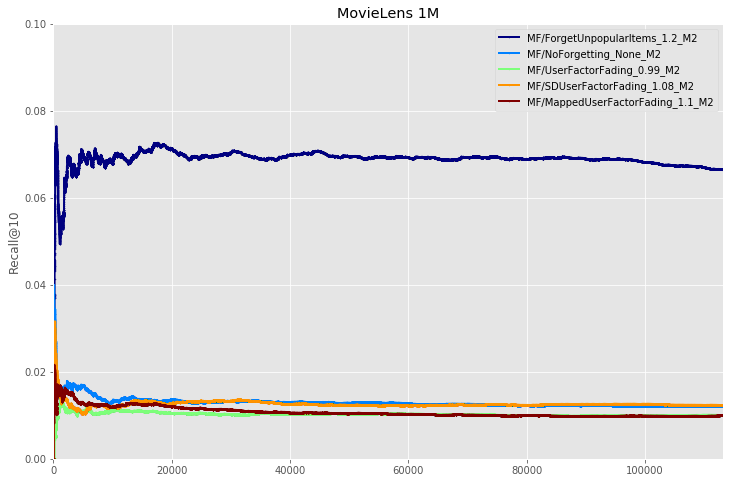

In [6]:
plt.rcParams['figure.figsize'] = (12,8)
with plt.style.context(('ggplot')):
    ax = recallDF.plot(lw=2, colormap='jet', marker='.', markersize=1, title="MovieLens 1M")
    plt.ylim([0,0.1])
    ax.set(xlabel="", ylabel='Recall@{}'.format(__RECALLAT__))

In [7]:
recallDF.mean()

MF/ForgetUnpopularItems_1.2_M2      0.068915
MF/NoForgetting_None_M2             0.013010
MF/UserFactorFading_0.99_M2         0.010310
MF/SDUserFactorFading_1.08_M2       0.012644
MF/MappedUserFactorFading_1.1_M2    0.010804
dtype: float64